In [1]:
from zipdl.algos import multi_factor_training as mf
from datetime import datetime as dt
from zipline import run_algorithm
import pandas as pd
import numpy as np

In [20]:
#sample_weights = [.5, .5]
sample_weights = [1]
start = pd.to_datetime('2018-01-01').tz_localize('US/Eastern')
end = pd.to_datetime('2018-02-01').tz_localize('US/Eastern')
start_capital = 5000

In [2]:
%%bash
zipline ingest -b quantopian-quandl

[2018-04-11 06:52:51.832443] INFO: zipline.data.bundles.quandl: Writing data to /home/austen/.zipline/data/quantopian-quandl/2018-04-11T06;52;29.146211.


In [3]:
from zipdl.utils import utils
from zipdl.data import models as m

In [4]:
utils.clean_db_time_series(mf.DB_FACTORS_USED)

cleaning Shares_Outstanding
cleaning EBITDA
cleaning Short term debt
cleaning Long Term Debt
cleaning Cash and Cash EquivalentsTotal Assets
cleaning Total Liabilities
cleaning Free Cash Flow


In [5]:
utils.clean_db_time_series(['Cash and Cash Equivalents', 'Total Assets'])

cleaning Cash and Cash Equivalents
cleaning Total Assets


In [6]:
print(utils.get_fundamental(start, 'EBITDA', 'AAPL'))
print(utils.get_fundamental(start, 'Short term debt', 'AAPL'))
print(utils.get_fundamental(start, 'Long Term Debt', 'AAPL'))
print(utils.get_fundamental(start, 'EBITDA', 'AAPL'))
print(utils.get_fundamental(start, 'Cash and Cash Equivalents', 'AAPL'))
print(utils.get_fundamental(start, 'Total Assets', 'AAPL'))
print(utils.get_fundamental(start, 'Total Liabilities', 'AAPL'))
print(utils.get_fundamental(start, 'Shares_Outstanding', 'AAPL'))

71501.0
140458.0
35867.0
71501.0
74181.0
375319.0
241272.0
5087.056


In [7]:
from zipdl.data import models as m
def get_fundamentals(date, fundamental, tickers, session=utils.session):
    data = session.query(m.Fundamentals).filter(m.Fundamentals.metric==fundamental).all()
    data = [obj for obj in data if obj.ticker in tickers]
    dict_tickers = [obj.ticker for obj in data]
    data.sort(key = lambda obj: tickers.index(obj.ticker))
    def get_close(obj, date):
        #print(obj.ticker)
        if not obj.time_series:
            return np.nan
        close = utils.find_closest_date(obj.time_series.keys(), date)
        return obj.time_series[close]
    values = [get_close(obj, date) for obj in data]
    dictionary = dict(zip(dict_tickers, values))
    def ret_correct(ticker):
        if ticker in dict_tickers:
            index = dict_tickers.index(ticker)
            return values[index]
        return np.nan
    return [ret_correct(ticker) for ticker in tickers]


In [16]:
start = pd.to_datetime('2017-01-01').tz_localize('US/Eastern')
end = pd.to_datetime('2018-02-01').tz_localize('US/Eastern')

In [35]:
import numpy as np
import pandas as pd
from numexpr import evaluate
import zipline

from zipline.pipeline.factors.technical import RSI
from zipline.finance import commission, slippage
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.filters import StaticAssets
from zipline.data import bundles
from zipline.api import *
from zipline.pipeline.data import USEquityPricing
from zipline.utils.math_utils import nanmean, nanstd
from zipline.finance.slippage import FixedSlippage

from zipdl.utils import utils
import datetime as dt

# Weeks between a rebalance
REBALANCE_PERIOD = 4

# Lookback window, in days, for Momentum (Bollinger Bands and RSI) factor
MOMENTUM_LOOKBACK = 30

# If true, will switch from mean-reverting to trend-following momentum
TREND_FOLLOW = True

# Upper/lower SD's required for Bollinger Band signal
BBUPPER = 1.5
BBLOWER = 1.5
BBSTD = 1.5

NORMALIZE_VALUE_SCORES = False

# Upper/lower scores required for RSI signal
RSI_LOWER = 30
RSI_UPPER = 70

# Percentile in range [0, 1] of stocks that are shorted/bought
SHORTS_PERCENTILE = 0.01
LONGS_PERCENTILE = 0.01

# Constraint Parameters
MAX_GROSS_LEVERAGE = 1.0

DOLLAR_NEUTRAL = False

# If True, will screen out companies that have earnings releases between rebalance periods
AVOID_EARNINGS = True

# If False, shorts won't be ordered
ALLOW_SHORTS = True

# If True, will cut positions causing losses of LOSS_THRESHOLD or more
CUT_LOSSES = False

# Positions losing this much or more as a fraction of the investment will be cut if CUT_LOSSES is True
LOSS_THRESHOLD = 0.03

# Whether or not to print pipeline output stats. For backtest speed, turn off.
PRINT_PIPE = False

#=================util=============================
#Throws out tickers not found in quandl-quantopian data (mostly tickers with no vol)
def safe_symbol(ticker):
    try:
        x = symbol(ticker)
        return x
    except: 
        return None
def safe_symbol_convert(tickers):
    filtered_list = list(filter(None.__ne__, [safe_symbol(ticker) for ticker in tickers]))
    return filtered_list

def universe_transform(date):
    universe = utils.get_current_universe(date)
    tradable_assets = safe_symbol_convert(universe)
    return tradable_assets

#==================PRIMARY==========================
def initialize_environment(weight, trading_start):
    def initialize(context):
        set_commission(commission.PerShare(cost=0.005, min_trade_cost=1.00))
        set_slippage(slippage.FixedSlippage(0.00))
        context.universe = universe_transform(trading_start)

        context.Factor_weights = weight
        context.curr_date = trading_start

        schedule_function(rebalance_portfolio, date_rules.week_start(days_offset=2), time_rules.market_open(hours=1))
        
        #schedule_function(cancel_open_orders, date_rules.every_day(), time_rules.market_open())

        schedule_function(prime_pipeline, date_rules.week_start(days_offset=1), time_rules.market_close())

        context.weights = None
        context.run_pipeline = True #We want to run stock selector immediately
        context.weeks_since_rebalance = -1

        attach_pipeline(make_pipeline(context), 'my_pipeline')


    return initialize
#schedule trading monthly
#schedule stop loss/take gain daily

def handle_data(context, data):
    #Daily function
    context.curr_date += dt.timedelta(days=1)
    #context.universe = universe_transform(context.curr_date)

def rebalance_portfolio(context, data):
    # rebalance portfolio
    close_old_positions(context, data)
    #order_target(symbol('AAPL'), 5)
    total_weight = np.sum(context.weights.abs())
    weights = context.weights / total_weight
    for stock, weight in weights.items():
        order_target_percent(stock, weight)
        
def before_trading_start(context, data):
    if not context.run_pipeline:
        return
    
    context.run_pipeline = False
    def compute(today, symbols, close):
        #for verification
        tickers = [symbol.symbol for symbol in symbols]
        
        shares_outstanding = np.array(get_fundamentals(today, 'Shares_Outstanding', tickers))
        market_cap = close * shares_outstanding
        #ev_to_ebitda
        ebitda = np.array(get_fundamentals(today, 'EBITDA', tickers))
        shortTermDebt = np.array(get_fundamentals(today, 'Short term debt', tickers))
        longTermDebt = np.array(get_fundamentals(today, 'Long Term Debt', tickers))
        c_and_c_equivs = np.array(get_fundamentals(today, 'Cash and Cash Equivalents', tickers))
        ev = shortTermDebt + longTermDebt + market_cap - c_and_c_equivs
        ebitda_to_ev = ebitda / ev
        
        #Book to price
        totalAssets = np.array(get_fundamentals(today, 'Total Assets', tickers))
        totalLiab = np.array(get_fundamentals(today, 'Total Liabilities', tickers))
        book_to_price = (totalAssets - totalLiab) / shares_outstanding

        fcf = np.array(get_fundamentals(today, 'Free Cash Flow', tickers))
        fcf_yield = fcf / close

        values = ebitda_to_ev * book_to_price * fcf_yield
        #print(values)
        out = pd.Series(values, symbols)
        return out
    #close = np.array([data.current(symbol, 'price') for symbol in context.universe])
    #value_factor = compute(context.curr_date, context.universe, close).to_frame()
    context.output = pipeline_output('my_pipeline')
    #context.output = context.output.join(value_factor).dropna()

    # Do some pre-work on factors
    if NORMALIZE_VALUE_SCORES:
        normalizeValueScores(context)
    
    # Rank each column of pipeline output (higher rank is better). Then create composite score based on weighted average of factor ranks
    individual_ranks = context.output.rank()
    individual_ranks *= context.Factor_weights
    ranks = individual_ranks.sum(axis=1).dropna().sort_values() + 1

    
    number_shorts = int(SHORTS_PERCENTILE*len(ranks))
    number_longs = int(LONGS_PERCENTILE*len(ranks))
    
    if number_shorts == 1 or number_longs == 1:
        number_shorts = number_longs = 0

    if (number_shorts + number_longs) > len(ranks):
        ratio = float(number_longs)/number_shorts
        number_longs = int(ratio*len(ranks)) - 1
        number_shorts = len(ranks) - number_longs
        
    shorts = 1.0 / ranks.head(number_shorts)
    shorts /= sum(shorts)
    shorts *= -1
    
    longs = ranks.tail(number_longs)
    longs /= sum(longs)
    
    if ALLOW_SHORTS:
        context.weights = shorts.append(longs)
    else:
        context.weights = longs
    # log.info(context.weights)
    

#==================UTILS==========================

def cancel_open_orders(context, data):
    for stock in get_open_orders():
        for order in get_open_orders(stock):
            cancel_order(order)

def close_old_positions(context, data):
    to_be_closed = pd.Series()
    for stock in context.portfolio.positions:
        if stock not in context.weights:
            to_be_closed.set_value(stock, 0.0)
            
    context.weights = to_be_closed.append(context.weights)

#===================FACTORS=========================
DB_FACTORS_USED = ['Shares_Outstanding', 'EBITDA', 'Short term debt', 'Long Term Debt', 'Cash and Cash Equivalents',
                    'Total Assets', 'Total Liabilities', 'Free Cash Flow']

class MomentumFactor(CustomFactor):
    """
    Uses Bollinger Bands and RSI measures to determine whether or not a stock 
    should be bought (return 1), sold (return -1), or if there is no signal 
    (return 0). For a signal, both metrics have to indicate the same signal 
    (e.g., price below lower Bollinger Band and RSI below RSI_LOWER)
    """
    inputs = [USEquityPricing.close]
    window_length = MOMENTUM_LOOKBACK+10
    
    def compute(self, today, asset_ids, out, close):
        diffs = np.diff(close, axis=0)
        ups = nanmean(np.clip(diffs, 0, np.inf), axis=0)
        downs = abs(nanmean(np.clip(diffs, -np.inf, 0), axis=0))
        rsi = np.zeros(len(out))
        evaluate(
            "100 - (100 / (1 + (ups / downs)))",
            local_dict={'ups': ups, 'downs': downs},
            global_dict={},
            out=rsi,
        )
        
        difference = BBSTD * nanstd(close, axis=0)
        middle = nanmean(close, axis=0)
        upper = middle + difference
        lower = middle - difference

        for i in range(len(out)):
            out[i] = 0
            if rsi[i] < RSI_LOWER:
                out[i] += RSI_LOWER / rsi[i]
            elif rsi[i] > RSI_UPPER:
                out[i] -= rsi[i] / RSI_UPPER
                
            prices = close[:, i]
            if prices[-1] < lower[i]:
                out[i] += lower[i] / prices[-1]
            elif prices[-1] > upper[i]:
                out[i] -= prices[-1] / upper[i]
                
            if TREND_FOLLOW:
                out[i] *= -1
#============================Pipeline Stuff=============================
def make_pipeline(context):
    
    screen = StaticAssets(context.universe)

    momentum_factor = MomentumFactor()
    pipe = Pipeline(
        columns = {
            'momentum_score': momentum_factor,
        }
    )
    pipe.set_screen(screen)
    return pipe
def prime_pipeline(context, data):
    context.weeks_since_rebalance += 1
    if context.weeks_since_rebalance >= REBALANCE_PERIOD:
        context.run_pipeline = True
        context.weeks_since_rebalance = 0



In [36]:
import timeit

In [37]:
start, end

(Timestamp('2018-01-01 00:00:00-0500', tz='US/Eastern'),
 Timestamp('2018-02-01 00:00:00-0500', tz='US/Eastern'))

In [38]:
initialize = initialize_environment(sample_weights, start)
begin = timeit.default_timer()
perf = run_algorithm(start, end, 
                    initialize=initialize, 
                    capital_base=start_capital, 
                    before_trading_start=before_trading_start,
                    metrics_set='faster')
stop = timeit.default_timer()
print(stop - begin)

22.67816862499967


In [44]:
len(dict({x : 1 for x in 'abc'}))

3

In [23]:
perf

,algorithm_period_return,period_close,period_open,returns,sortino
2018-01-02 21:00:00+00:00,0.000000,2018-01-02 21:00:00+00:00,2018-01-02 14:31:00+00:00,0.000000,NaN
2018-01-03 21:00:00+00:00,0.000000,2018-01-03 21:00:00+00:00,2018-01-03 14:31:00+00:00,0.000000,NaN
2018-01-04 21:00:00+00:00,0.000000,2018-01-04 21:00:00+00:00,2018-01-04 14:31:00+00:00,0.000000,NaN
2018-01-05 21:00:00+00:00,-0.003066,2018-01-05 21:00:00+00:00,2018-01-05 14:31:00+00:00,-0.003066,-7.937254
2018-01-08 21:00:00+00:00,-0.004420,2018-01-08 21:00:00+00:00,2018-01-08 14:31:00+00:00,-0.001358,-9.366286
2018-01-09 21:00:00+00:00,-0.000762,2018-01-09 21:00:00+00:00,2018-01-09 14:31:00+00:00,0.003674,-1.450092
2018-01-10 21:00:00+00:00,0.000826,2018-01-10 21:00:00+00:00,2018-01-10 14:31:00+00:00,0.001590,1.501697
2018-01-11 21:00:00+00:00,0.002452,2018-01-11 21:00:00+00:00,2018-01-11 14:31:00+00:00,0.001625,4.123890
2018-01-12 21:00:00+00:00,0.001828,2018-01-12 21:00:00+00:00,2018-01-12 14:31:00+00:00,-0.000623,2.856308
2018-01-16 21:00:00+00:00,-0.004888,2018-01-16 21:00:00+00:00,2018-01-16 14:31:00+00:00,-0.006703,-3.245190


In [25]:
import empyrical
empyrical.sortino_ratio(perf['algorithm_period_return'], period=empyrical.MONTHLY)

2.3557310677480183

In [12]:
from zipline.finance.metrics import core
core.metrics_sets

mappingproxy({'classic': <function zipline.finance.metrics.classic_metrics>,
              'default': <function zipline.finance.metrics.default_metrics>,
              'faster': <function zipline.finance.metrics.default_metrics>,
              'none': set})

In [40]:
import matplotlib.pyplot as plt

In [41]:
def initialize(context):
    context.i = 0
    context.asset = symbol('AAPL')


def handle_data(context, data):
    # Skip first 300 days to get full windows
    context.i += 1
    if context.i < 300:
        return

    # Compute averages
    # data.history() has to be called with the same params
    # from above and returns a pandas dataframe.
    short_mavg = data.history(context.asset, 'price', bar_count=100, frequency="1d").mean()
    long_mavg = data.history(context.asset, 'price', bar_count=300, frequency="1d").mean()

    # Trading logic
    if short_mavg > long_mavg:
        # order_target orders as many shares as needed to
        # achieve the desired number of shares.
        order_target(context.asset, 100)
    elif short_mavg < long_mavg:
        order_target(context.asset, 0)

    # Save values for later inspection
    record(AAPL=data.current(context.asset, 'price'),
           short_mavg=short_mavg,
           long_mavg=long_mavg)
def analyze(context, perf):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    perf.portfolio_value.plot(ax=ax1)
    ax1.set_ylabel('portfolio value in $')

    ax2 = fig.add_subplot(212)
    perf['AAPL'].plot(ax=ax2)
    perf[['short_mavg', 'long_mavg']].plot(ax=ax2)

    perf_trans = perf.ix[[t != [] for t in perf.transactions]]
    buys = perf_trans.ix[[t[0]['amount'] > 0 for t in perf_trans.transactions]]
    sells = perf_trans.ix[
        [t[0]['amount'] < 0 for t in perf_trans.transactions]]
    ax2.plot(buys.index, perf.short_mavg.ix[buys.index],
             '^', markersize=10, color='m')
    ax2.plot(sells.index, perf.short_mavg.ix[sells.index],
             'v', markersize=10, color='k')
    ax2.set_ylabel('price in $')
    plt.legend(loc=0)
    plt.show()

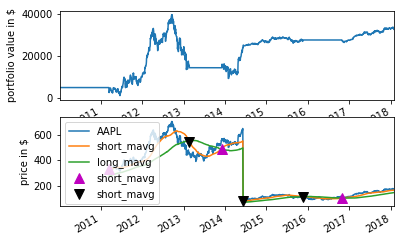

,AAPL,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,...,short_mavg,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2010-01-04 21:00:00+00:00,NaN,NaN,0.000000,NaN,-0.014612,NaN,NaN,0.0,5000.0000,0.0,...,NaN,0.0,0,NaN,5000.0000,0.0,0.0,1,[],0.0
2010-01-05 21:00:00+00:00,NaN,0.000000,0.000000,NaN,-0.029010,0.000000,NaN,0.0,5000.0000,0.0,...,NaN,0.0,0,NaN,5000.0000,0.0,0.0,2,[],0.0
2010-01-06 21:00:00+00:00,NaN,0.000000,0.000000,NaN,-0.043198,0.000000,NaN,0.0,5000.0000,0.0,...,NaN,0.0,0,NaN,5000.0000,0.0,0.0,3,[],0.0
2010-01-07 21:00:00+00:00,NaN,0.000000,0.000000,NaN,-0.057179,0.000000,NaN,0.0,5000.0000,0.0,...,NaN,0.0,0,NaN,5000.0000,0.0,0.0,4,[],0.0
2010-01-08 21:00:00+00:00,NaN,0.000000,0.000000,NaN,-0.070955,0.000000,NaN,0.0,5000.0000,0.0,...,NaN,0.0,0,NaN,5000.0000,0.0,0.0,5,[],0.0
2010-01-11 21:00:00+00:00,NaN,0.000000,0.000000,NaN,-0.084530,0.000000,NaN,0.0,5000.0000,0.0,...,NaN,0.0,0,NaN,5000.0000,0.0,0.0,6,[],0.0
2010-01-12 21:00:00+00:00,NaN,0.000000,0.000000,NaN,-0.097907,0.000000,NaN,0.0,5000.0000,0.0,...,NaN,0.0,0,NaN,5000.0000,0.0,0.0,7,[],0.0
2010-01-13 21:00:00+00:00,NaN,0.000000,0.000000,NaN,-0.111088,0.000000,NaN,0.0,5000.0000,0.0,...,NaN,0.0,0,NaN,5000.0000,0.0,0.0,8,[],0.0
2010-01-14 21:00:00+00:00,NaN,0.000000,0.000000,NaN,-0.124077,0.000000,NaN,0.0,5000.0000,0.0,...,NaN,0.0,0,NaN,5000.0000,0.0,0.0,9,[],0.0
2010-01-15 21:00:00+00:00,NaN,0.000000,0.000000,NaN,-0.136876,0.000000,NaN,0.0,5000.0000,0.0,...,NaN,0.0,0,NaN,5000.0000,0.0,0.0,10,[],0.0


In [42]:
start = pd.to_datetime('2010-01-01').tz_localize('US/Eastern')
end = pd.to_datetime('2018-02-01').tz_localize('US/Eastern')
perf = run_algorithm(start, end, 
                    initialize=initialize, 
                    capital_base=start_capital, 
                    handle_data=handle_data,
                    analyze=analyze)
perf

In [10]:
z = utils.get_current_universe(start)
len(z)

1199

In [11]:
'AA' in z

False

In [ ]:
for ticker in tickers:
    print(ticker)
    utils.get_fund

[utils.get_fundamental(today, 'Shares_Outstanding', ticker) for ticker in tickers]

In [5]:
import quandl
import os
quandl.ApiConfig.api_key = os.environ['QUANDL_KEY']

In [38]:
start_str = '2015-02-03, 2015-02-04, 2015-02-05'
counter = 0
n_a = []
for ticker in z:
    if quandl.get_table('WIKI/PRICES', ticker=ticker.replace(' ', ''), date=start_str).empty:
        print(ticker)
        counter += 1
        n_a.append(ticker)

USAT
CYAN
RWC
CGA
AGI
FKWL
EEI
NERV
TRNS
ALV
ZHNE
FORD
AMRK
SPAN
DDMG
FONR
CIK
BRID
AKER
ITI
HNNA
NSHI
FRD
C208
RYAM
AMDA
CPXX
MGCD
IHT
MTII
TTLO
FDC
PRGB
SEV
EEP
ESP
GLPI
BSTG
BOOT
BLUD
RICK
LRDC
SMED
SOHU
WPC
MAYS
TSQ
QVC
RMCF
SINO
KLIC
JAZZ
CDNA
VALU
CLRB
NSPR
BGSF
DNOW
PSEG
SMID
SKY
VERU
DYNT
CNVR
SRNE
CIK0
VIRC
DTRM
GLGI
EFH
SAGE
ZYXI
ACPW
CCS
CETX
TSSI
ADPT
LPTH
INFOR
MAMS
SRT
AWRE
HYH
NHTC
NPS
ON
HDSN
VRS
IMSCQ
IDSY
GPRO
TST
SMSI
CK00015503
IVDN
SPGI
GENC
LTRX
AAXN
PMD
CATS
LEATPK
OLIN
AIRI
SMIT
HGEN
PPSI
CENT
AR
C214
TMED
PERF
JWA
W
AGHI
NLSNNV
WNDW
CMD
INFU
C730
CCFI
NLST
ASNB
UA
TPCS
CHKE
LOGI
NSSC
PSDV
NAII
TBTC
OGES
WSCI
SIMU
GTLT
SHPGF
WINH
ERS
TSRI
ADAT
SOHO
RFMD
MIC
KTEC
PSTI
CNNX
ACT
TA
BMRA
DGTC
MTBC
SCND
NCSO
CAGU
KE
CPAH
BFB
SRC
NGL
SLNM
PSSR
BVSN
LULU
PRTX
KATE
GIDYL
UG
LEDS
CLNT
MHH
BLFS
IIN
FLEX
AJRD
TSE
AEHR
ANET
TLCC
STAY
FLUG
CRWS
ELMD
TAYD
CIK0001446
EPD
JVA
BX
CSBR
IEHC
BRX
AMOT
IAIC
ETEC
ABCD
ENG
ALT
SOFO
NEPH
ABTL
AMH
DDE
BRRE
C099
ABMC
SOTK
OCC
DPLO
AHPI
B

In [39]:
len(n_a)

243